# Internet traffic attack recognition (ShieldNet - multiclass)

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
if not torch.cuda.is_available():
    quit()
else:
    print("Cuda capable device found!")

Cuda capable device found!


# Get the datasets from memory

Assumption: dataset has its colums' names stripped from white spaces, no NaNs or +-Inf

In [2]:
ds_selector='.\\datasets\\CICDDoS2019\\cut'

In [3]:
csv_files = []
for dirname, _, filenames in os.walk(ds_selector):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        csv_files.append(csv_file)
csv_files

['.\\datasets\\CICDDoS2019\\cut\\dataset.csv']

In [4]:
if len(csv_files) > 1:
    df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
else:
    df = pd.read_csv(csv_files[0])
    
df.columns = df.columns.str.strip()
print("Original length of df:", len(df))

Original length of df: 1364839


## Tidy up the dataset

In [5]:
#df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364839 entries, 0 to 1364838
Data columns (total 80 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Destination Port             1364839 non-null  int64  
 1   Flow Duration                1364839 non-null  int64  
 2   Total Fwd Packets            1364839 non-null  int64  
 3   Total Backward Packets       1364839 non-null  int64  
 4   Total Length of Fwd Packets  1364839 non-null  float64
 5   Total Length of Bwd Packets  1364839 non-null  float64
 6   Fwd Packet Length Max        1364839 non-null  float64
 7   Fwd Packet Length Min        1364839 non-null  float64
 8   Fwd Packet Length Mean       1364839 non-null  float64
 9   Fwd Packet Length Std        1364839 non-null  float64
 10  Bwd Packet Length Max        1364839 non-null  float64
 11  Bwd Packet Length Min        1364839 non-null  float64
 12  Bwd Packet Length Mean       1364839 non-n

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("After dropping NaNs, the length of df:", len(df))
df.drop_duplicates(keep='first', inplace=True)

After dropping NaNs, the length of df: 1364839


In [7]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        print('Removing column', str(col))
        df.drop(col,inplace=True,axis=1)

Removing column Bwd PSH Flags
Removing column Fwd URG Flags
Removing column Bwd URG Flags
Removing column FIN Flag Count
Removing column PSH Flag Count
Removing column ECE Flag Count
Removing column Fwd Avg Bytes/Bulk
Removing column Fwd Avg Packets/Bulk
Removing column Fwd Avg Bulk Rate
Removing column Bwd Avg Bytes/Bulk
Removing column Bwd Avg Packets/Bulk
Removing column Bwd Avg Bulk Rate


In [8]:
df.Label.value_counts()

NTP        113588
MSSQL      113456
SSDP       112877
UDP        112564
NetBIOS    110473
DNS        110194
UDPLag     109388
LDAP       107334
BENIGN      99814
SNMP        99489
Syn         96117
TFTP        79740
Name: Label, dtype: int64

C:\Users\MAX\AppData\Local\Temp\ipykernel_24136\2263113112.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat=df.corr()


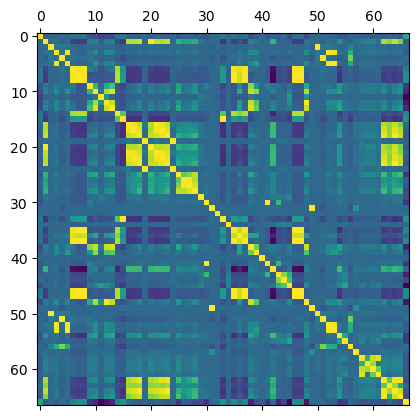

In [9]:
corr_mat=df.corr()
plt.matshow(corr_mat)
plt.show()

## Getting ready for learning

In [10]:
cols=df.columns.to_list()
print(cols)
print(len(cols))

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Le

In [11]:
for i in range(len(df.columns)):
    if cols[i] != 'Label':
        print(i, cols[i], ', Std:', df.iloc[:,i].std(), ', Avg:', df.iloc[:,i].mean())

0 Destination Port , Std: 20065.44386798694 , Avg: 31134.598961767035
1 Flow Duration , Std: 22057683.372563638 , Avg: 5809564.848787463
2 Total Fwd Packets , Std: 251.1930606911631 , Avg: 12.11037568950716
3 Total Backward Packets , Std: 32.96114848157505 , Avg: 0.8502316933774112
4 Total Length of Fwd Packets , Std: 21888.284298032868 , Avg: 4687.674991344106
5 Total Length of Bwd Packets , Std: 62141.41778267717 , Avg: 560.2030577834272
6 Fwd Packet Length Max , Std: 533.0267527314651 , Avg: 528.9548099102475
7 Fwd Packet Length Min , Std: 532.3150149505611 , Avg: 505.214396609103
8 Fwd Packet Length Mean , Std: 527.713553006793 , Avg: 515.5258337699454
9 Fwd Packet Length Std , Std: 43.239394972436 , Avg: 8.51644969755063
10 Bwd Packet Length Max , Std: 291.09252194812854 , Avg: 28.036039347559036
11 Bwd Packet Length Min , Std: 20.38602379864074 , Avg: 2.884123272576073
12 Bwd Packet Length Mean , Std: 75.46092255627795 , Avg: 9.037367239607836
13 Bwd Packet Length Std , Std: 77.0

In [12]:
%store -r classes_distribution_cut
classes_ids={}
classes_ids=classes_ids.fromkeys(classes_distribution_cut)

one_hot_encoding=torch.nn.functional.one_hot(torch.arange(0,len(classes_distribution_cut)),num_classes=len(classes_distribution_cut))
one_hot_encoding

for idx,(k,_) in enumerate(classes_ids.items()):
    classes_ids[k]=(idx,one_hot_encoding[idx])

classes_ids

{'DNS': (0, tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'BENIGN': (1, tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'LDAP': (2, tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'MSSQL': (3, tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])),
 'NetBIOS': (4, tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])),
 'NTP': (5, tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])),
 'SNMP': (6, tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])),
 'SSDP': (7, tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])),
 'UDP': (8, tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])),
 'Syn': (9, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])),
 'TFTP': (10, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])),
 'UDPLag': (11, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))}

In [13]:
replacement_dict={}
replacement_dict_cass_to_id={}
replacement_dict.fromkeys(classes_ids)
for k,(idx, tensor) in classes_ids.items():
    replacement_dict[idx]=tensor
    replacement_dict_cass_to_id[k]=idx

replacement_dict

{0: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 1: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 2: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 3: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 4: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 5: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 6: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 7: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 8: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 9: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 10: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 11: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [14]:
replacement_dict_cass_to_id

{'DNS': 0,
 'BENIGN': 1,
 'LDAP': 2,
 'MSSQL': 3,
 'NetBIOS': 4,
 'NTP': 5,
 'SNMP': 6,
 'SSDP': 7,
 'UDP': 8,
 'Syn': 9,
 'TFTP': 10,
 'UDPLag': 11}

In [15]:
df.replace({'Label':replacement_dict_cass_to_id}, inplace=True)
X=df.iloc[:,:67]
Y=df.iloc[:,67]

In [16]:
tot_col=df.columns.tolist()
tot_col=[(idx,x) for idx,x in enumerate(tot_col)]
tot_col

[(0, 'Destination Port'),
 (1, 'Flow Duration'),
 (2, 'Total Fwd Packets'),
 (3, 'Total Backward Packets'),
 (4, 'Total Length of Fwd Packets'),
 (5, 'Total Length of Bwd Packets'),
 (6, 'Fwd Packet Length Max'),
 (7, 'Fwd Packet Length Min'),
 (8, 'Fwd Packet Length Mean'),
 (9, 'Fwd Packet Length Std'),
 (10, 'Bwd Packet Length Max'),
 (11, 'Bwd Packet Length Min'),
 (12, 'Bwd Packet Length Mean'),
 (13, 'Bwd Packet Length Std'),
 (14, 'Flow Bytes/s'),
 (15, 'Flow Packets/s'),
 (16, 'Flow IAT Mean'),
 (17, 'Flow IAT Std'),
 (18, 'Flow IAT Max'),
 (19, 'Flow IAT Min'),
 (20, 'Fwd IAT Total'),
 (21, 'Fwd IAT Mean'),
 (22, 'Fwd IAT Std'),
 (23, 'Fwd IAT Max'),
 (24, 'Fwd IAT Min'),
 (25, 'Bwd IAT Total'),
 (26, 'Bwd IAT Mean'),
 (27, 'Bwd IAT Std'),
 (28, 'Bwd IAT Max'),
 (29, 'Bwd IAT Min'),
 (30, 'Fwd PSH Flags'),
 (31, 'Fwd Header Length'),
 (32, 'Bwd Header Length'),
 (33, 'Fwd Packets/s'),
 (34, 'Bwd Packets/s'),
 (35, 'Min Packet Length'),
 (36, 'Max Packet Length'),
 (37, 'Packet

In [17]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, shuffle=True, train_size=0.75)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, shuffle=True, train_size=0.75)
del X,Y

trainY=pd.Series(trainY)
valY=pd.Series(valY)

f:\miniconda\envs\dl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
from sklearn.preprocessing import StandardScaler
scalerX_train = StandardScaler()
X_scaled_train=scalerX_train.fit_transform(trainX)

In [19]:
from torch import tensor
from torch.utils.data import Dataset, DataLoader

class NetMetrics(Dataset):
    def __init__(self, X, y, one_hot):
        self.x, self.y, self.one_hot = X, y, one_hot
        self.len=self.x.shape[0]

    def __getitem__(self,index):
        tensor_label=one_hot_encoding[self.y.iloc[index]]
        return tensor(self.x[index,:], dtype=torch.float32), tensor_label.float()
        
    def __len__(self):
        return self.len

ds=NetMetrics(X_scaled_train, trainY, replacement_dict)

## The model

In [20]:
class AttackNet(torch.nn.Module):

    def __init__(self):
        super(AttackNet, self).__init__()
        self.model=torch.nn.Sequential(
            torch.nn.Linear(67, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 12),
            torch.nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        return self.model(x)

def init_weights(module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.0001)


model = AttackNet()
model.apply(init_weights)

AttackNet(
  (model): Sequential(
    (0): Linear(in_features=67, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=12, bias=True)
    (9): LogSoftmax(dim=1)
  )
)

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Training

In [22]:
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

epochs=50
learning_rate = .001
model=model.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
loader = DataLoader(dataset=ds, batch_size=100, shuffle=True)

# Early stopping
last_loss = np.inf
patience = 3
trigger_times = 0

In [23]:
def model_validation(criterion):

    #val_tar=[]
    #val_pred=[]
    cumulative_L_val=0.

    val_ds = NetMetrics(scalerX_train.transform(testX), testY, replacement_dict)
    val_loader=DataLoader(val_ds, batch_size=100, shuffle=False)

    model.eval()

    with torch.no_grad():
        for inputs, ground_truth in val_loader:
            y_tilde = model(inputs.to(device))
            y=ground_truth

            loss_val=criterion(y_tilde, y.to(device))
            cumulative_L_val+=loss_val.item()
           
            #val_tar.append(y)
            #val_pred.append(y_tilde.clone().detach())
    
        #f1=BinaryF1Score()
        #f1_val=f1(tensor(val_pred), tensor(val_tar))

        #print('F1-score Val: ', f1_val)
    
    #return f1_val
    return cumulative_L_val

In [25]:
def model_train(epoch, optimizer, model):
    model.train()
    
    print("Epoch begin: ", epoch)
    cumulative_L_train = 0.
    for x,y in loader:
        # reset optimizer
        opt.zero_grad()
        loss = criterion(model(x.to(device)), y.to(device))
        loss.backward()
        opt.step()
        cumulative_L_train+=loss.item()

    return cumulative_L_train

In [26]:
#out=[]
for epoch in range(epochs):

    
    loss_train=model_train(epoch, opt, model)
    writer.add_scalar("Loss/Train", loss_train , epoch)
    
    loss_val=model_validation(criterion)
    scheduler.step()

    writer.add_scalar("Loss/Val", loss_val , epoch)

    writer.add_scalars("Loss/General", {"Train": loss_val, "Val": loss_train}, epoch)

    #EarlyStopping
    if loss_val > last_loss:
        trigger_times += 1
        print('No improvement detected')

    if trigger_times >= patience:
        print('Early stopping triggered')
        continue #exit now
    else:
        trigger_times = 0

    last_loss = loss_val

    #out.append(cumulative_L)

writer.close()

#plt.plot(out)

Epoch begin:  0
Epoch begin:  1
Epoch begin:  2
Epoch begin:  3
No improvement detected
Epoch begin:  4
Epoch begin:  5
Epoch begin:  6
No improvement detected
Epoch begin:  7
Epoch begin:  8
No improvement detected
Epoch begin:  9
Epoch begin:  10
Epoch begin:  11
Epoch begin:  12
No improvement detected
Epoch begin:  13
No improvement detected
Epoch begin:  14
Epoch begin:  15
No improvement detected
Epoch begin:  16
Epoch begin:  17
No improvement detected
Epoch begin:  18
Epoch begin:  19
Epoch begin:  20
Epoch begin:  21
Epoch begin:  22
Epoch begin:  23
Epoch begin:  24
No improvement detected
Epoch begin:  25
Epoch begin:  26
Epoch begin:  27
No improvement detected
Epoch begin:  28
Epoch begin:  29
Epoch begin:  30
Epoch begin:  31
Epoch begin:  32
Epoch begin:  33
Epoch begin:  34
Epoch begin:  35
No improvement detected
Epoch begin:  36
Epoch begin:  37
Epoch begin:  38
No improvement detected
Epoch begin:  39
Epoch begin:  40
Epoch begin:  41
Epoch begin:  42
No improvement 

In [27]:
from datetime import datetime
model_name='.\\models\\' + datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'__multi_opt_sched.model'
torch.save(model.state_dict(), model_name)

## Test

In [28]:
test_ds = NetMetrics(scalerX_train.transform(testX), testY, replacement_dict)
print(len(test_ds))
test_loader=DataLoader(test_ds, batch_size=100, shuffle=False)

316259


In [29]:
#model=AttackNet()
#model.load_state_dict(torch.load('.\\models\\12-19-2022_21-02-10__anova_binary_opt.model'))
model=model.to('cpu')
model.eval()

acc = [0]*12
translator=replacement_dict
targets=[]
preds=[]

model.eval()

with torch.no_grad():
    for inputs, ground_truth in test_loader:
        prediction = torch.argmax(model(inputs), dim=1)
        targ = torch.argmax(ground_truth, dim=1)

        targets.extend(targ.tolist())
        preds.extend(prediction.clone().detach().tolist())

    for p,t in zip(preds, targets):
        if p == t:
            acc[p]+=1

acc

[9197,
 24796,
 23656,
 21171,
 1515,
 27574,
 24470,
 7720,
 25192,
 11430,
 19819,
 10070]

In [30]:
val_count_test=testY.value_counts()
val_count_test

5     28281
3     28243
7     28199
8     28169
0     27826
4     27558
11    27463
2     26888
6     24967
1     24812
9     23971
10    19882
Name: Label, dtype: int64

In [32]:
acc_final=[a/val_count_test[idx] for idx, a in enumerate(acc)]
print('Per class accuracy: ', acc_final)

Per class accuracy:  [0.3305182203694387, 0.999355150733516, 0.8797976792621244, 0.7496016712105654, 0.05497496189854126, 0.9750008839857148, 0.9800937237153042, 0.273768573353665, 0.8943164471582236, 0.47682616494931374, 0.9968313046977165, 0.36667516294650987]


C:\Users\MAX\AppData\Local\Temp\ipykernel_24136\393865247.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds)


Precision:  tensor(0.7203)
Recall:  tensor(0.6648)
F1-score:  tensor(0.6208)
Overall Accuracy:  tensor(0.6648)


<AxesSubplot: >

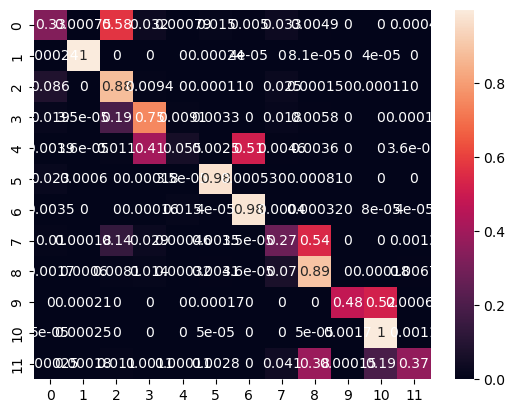

In [35]:
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy

target = torch.tensor(targets)
preds = torch.tensor(preds)
metric = MulticlassConfusionMatrix(12, normalize='true')
res=metric(preds, target)

prec = MulticlassPrecision(12)
print('Precision: ',prec(preds, target))

rec=MulticlassRecall(12)
print('Recall: ', rec(preds, target))

f1=MulticlassF1Score(12)
print('F1-score: ', f1(preds, target))

acc2=MulticlassAccuracy(12)
print('Overall Accuracy: ', acc2(preds, target))

import seaborn as sn
sn.heatmap(res, annot=True)

___